# Ranking with LSTM

In [1]:
from fastai.text.all import *
from IPython.display import display, HTML

import spacy
from spacy.symbols import ORTH

In [2]:
from ranking_utils import *

In [3]:
path = Path('./data/')

In [4]:
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: Tesla V100-PCIE-32GB


### Reading dataset

In [5]:
df = pd.read_csv(path/'cord-19_2020-07-16_ta_text.csv', index_col=0)

In [6]:
df.head()

,corduid,text
0,ug7v899j,"Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33..."
1,02tnwd4m,"Nitric oxide: a pro-inflammatory mediator in lung disease? Inflammatory diseases of the respiratory tract are commonly associated with elevated production of nitric oxide (NO•) and increased indices of NO• -dependent oxidative stress. Although NO• is known to have anti-microbial, anti-inflammatory and anti-oxidant properties, various lines of evidence support the contribution of NO• to lung injury in several disease models. On the basis of biochemical evidence, it is often presumed that such NO• -dependent oxidations are due to the formation of the oxidant peroxynitrite, although alternati..."
2,ejv2xln0,"Surfactant protein-D and pulmonary host defense Surfactant protein-D (SP-D) participates in the innate response to inhaled microorganisms and organic antigens, and contributes to immune and inflammatory regulation within the lung. SP-D is synthesized and secreted by alveolar and bronchiolar epithelial cells, but is also expressed by epithelial cells lining various exocrine ducts and the mucosa of the gastrointestinal and genitourinary tracts. SP-D, a collagenous calcium-dependent lectin (or collectin), binds to surface glycoconjugates expressed by a wide variety of microorganisms, and to o..."
3,2b73a28n,"Role of endothelin-1 in lung disease Endothelin-1 (ET-1) is a 21 amino acid peptide with diverse biological activity that has been implicated in numerous diseases. ET-1 is a potent mitogen regulator of smooth muscle tone, and inflammatory mediator that may play a key role in diseases of the airways, pulmonary circulation, and inflammatory lung diseases, both acute and chronic. This review will focus on the biology of ET-1 and its role in lung disease."
4,9785vg6d,"Gene expression in epithelial cells in response to pneumovirus infection Respiratory syncytial virus (RSV) and pneumonia virus of mice (PVM) are viruses of the family Paramyxoviridae, subfamily pneumovirus, which cause clinically important respiratory infections in humans and rodents, respectively. The respiratory epithelial target cells respond to viral infection with specific alterations in gene expression, including production of chemoattractant cytokines, adhesion molecules, elements that are related to the apoptosis response, and others that remain incompletely understood. Here we rev..."


### Word Tokenization

In [22]:
spacy = WordTokenizer()

In [23]:
txt = df['text'][0]
toks = first(spacy([txt]))
print(coll_repr(toks, 30))

(#391) ['Clinical','features','of','culture','-','proven','Mycoplasma','pneumoniae','infections','at','King','Abdulaziz','University','Hospital',',','Jeddah',',','Saudi','Arabia','OBJECTIVE',':','This','retrospective','chart','review','describes','the','epidemiology','and','clinical'...]


In [24]:
tkn = Tokenizer(spacy)
toks = tkn(txt)
print(coll_repr(toks, 30))

(#434) ['xxbos','xxmaj','clinical','features','of','culture','-','proven','xxmaj','mycoplasma','pneumoniae','infections','at','xxmaj','king','xxmaj','abdulaziz','xxmaj','university','xxmaj','hospital',',','xxmaj','jeddah',',','xxmaj','saudi','xxmaj','arabia','xxup'...]


### Numericalization

In [25]:
txts = L(df['text'][i] for i in range(10))
toks10 = txts.map(tkn)

In [26]:
num = Numericalize()
num.setup(toks10)
coll_repr(num.vocab)

"(#144) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj',','...]"

In [27]:
nums = num(toks)[:20]; nums

TensorText([ 2,  8, 61,  0, 11,  0, 14,  0,  8,  0, 62, 50, 76,  8,  0,  8,  0,  8,
         0,  8])

In [28]:
' '.join([num.vocab[n] for n in nums])

'xxbos xxmaj clinical xxunk of xxunk - xxunk xxmaj xxunk pneumoniae infections at xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj'

### DataBlock

In [15]:
class SpacyTokenizer25Mil():
    "Spacy tokenizer for `lang`"
    def __init__(self, lang='en', special_toks=None, buf_sz=5000):
        self.special_toks = ifnone(special_toks, defaults.text_spec_tok)
        nlp = spacy.blank(lang, disable=["parser", "tagger", "ner"])
        nlp.max_length = 25_000_000
        for w in self.special_toks: nlp.tokenizer.add_special_case(w, [{ORTH: w}])
        self.pipe,self.buf_sz = nlp.pipe,buf_sz

    def __call__(self, items):
        return (L(doc).attrgot('text') for doc in self.pipe(map(str,items), batch_size=self.buf_sz))

tkn = Tokenizer(SpacyTokenizer25Mil())

In [10]:
'''
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'), splitter=RandomSplitter(0.1)
).dataloaders(df, bs=128, seq_len=80)
'''
pass

In [9]:
dls_lm = TextDataLoaders.from_df(df, path=path, text_col='text', is_lm=True, bs=128, seq_len=80)
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj meta - analysis of bioabsorbable staple line reinforcement and risk of fistula following pancreatic resection . xxup background xxmaj stapled pancreatic transection is widely used although pancreatic fistula remains a common post - surgical complication . xxup methods xxmaj we performed a meta - analysis of existing data regarding pancreatic fistula following stapled pancreatic transection , comparing bare metal staples to reinforced staple loads . xxup results xxmaj we identified ten manuscripts between 2007 and 2009 reporting outcomes","xxmaj meta - analysis of bioabsorbable staple line reinforcement and risk of fistula following pancreatic resection . xxup background xxmaj stapled pancreatic transection is widely used although pancreatic fistula remains a common post - surgical complication . xxup methods xxmaj we performed a meta - analysis of existing data regarding pancreatic fistula following stapled pancreatic transection , comparing bare metal staples to reinforced staple loads . xxup results xxmaj we identified ten manuscripts between 2007 and 2009 reporting outcomes following"
1,"data related with severe acute respiratory syndrome coronavirus . xxmaj we finally focused on implications of immunotherapy treatments in clinical practice . xxbos coronavirus - pandemie ­ xxmaj xxunk an die grippe - epidemie von 1918 aus xxunk - xxunk xxmaj sicht . / [ coronavirus pandemic - memories of the flu epidemic from 1918 from a gynecological and obstetric perspective ] xxmaj from the medical reports on the flu epidemic in 1918 , there is accordance with the present","related with severe acute respiratory syndrome coronavirus . xxmaj we finally focused on implications of immunotherapy treatments in clinical practice . xxbos coronavirus - pandemie ­ xxmaj xxunk an die grippe - epidemie von 1918 aus xxunk - xxunk xxmaj sicht . / [ coronavirus pandemic - memories of the flu epidemic from 1918 from a gynecological and obstetric perspective ] xxmaj from the medical reports on the flu epidemic in 1918 , there is accordance with the present -"
2,"weaned calves on a commercial dairy farm . a total of 123 neonatal female calves , housed in individual hutches , were enrolled sequentially based on date of birth in 41 blocks of 3 animals each . xxmaj calves within each block were allocated to one of 3 treatments : remaining untreated , fed with xxup scfp ( diamond v xxunk ® at 1 g / d in milk and xxunk ® at 5 g / d in starter grain","calves on a commercial dairy farm . a total of 123 neonatal female calves , housed in individual hutches , were enrolled sequentially based on date of birth in 41 blocks of 3 animals each . xxmaj calves within each block were allocated to one of 3 treatments : remaining untreated , fed with xxup scfp ( diamond v xxunk ® at 1 g / d in milk and xxunk ® at 5 g / d in starter grain )"


In [10]:
torch.save(dls_lm, path/'lstm_ta_dls.pkl')

In [7]:
dls_lm = torch.load(path/'lstm_ta_dls.pkl')

### Fine-tuning Language model

In [8]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

#### Saving dataloader

SuggestedLRs(valley=0.0020892962347716093)

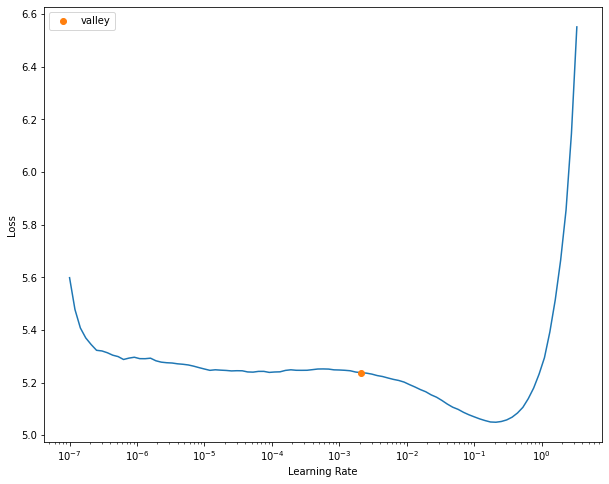

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.651961,3.525009,0.363783,33.954075,1:06:34


### Save and loading model

In [14]:
learn.save('lstm_1epoch')

Path('data/models/lstm_1epoch.pth')

In [18]:
learn = learn.load('lstm_1epoch')

In [15]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.302592,3.301427,0.389924,27.151346,1:09:44
1,3.190960,3.205628,0.399996,24.670992,1:10:03
2,3.114023,3.126412,0.409038,22.792063,1:08:41
3,3.015662,3.072189,0.415378,21.589102,1:06:15
4,2.943250,3.027709,0.420955,20.649864,1:09:04
5,2.852579,2.994771,0.425647,19.980793,1:06:57
6,2.753356,2.967702,0.430077,19.447172,1:06:59
7,2.713246,2.948751,0.433224,19.082109,1:07:41
8,2.640823,2.942184,0.434819,18.957199,1:06:05


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [16]:
learn.save('lstm_10epoch')

Path('data/models/lstm_10epoch.pth')

In [17]:
text = "Origin of corona "
n_words = 40
n_sentences = 2
preds = [learn.predict(text, n_words, temperature=0.75) for _ in range(n_sentences)]

In [19]:
print('\n'.join(preds))

Origin of corona - virus ( covid-19 ) Vaccines Innovation in Vaccinology is a process which has been facilitated by the development of a large number of vaccines and vaccines . The ability to provide human - to
Origin of corona virus : An evolutionary perspective The Corona virus , the result of the emergence of novel coronavirus in Wuhan , China in 2019 , is spreading all over the world . The virus is


### Constructing document embeddings

#### Tokenized text

In [20]:
learn.dls.train_ds.items.head()

,corduid,text,text_length
124066,s0pjwber,"[xxbos, xxmaj, implications, of, sars, -, cov-2, xxmaj, infection, and, xxup, covid-19, xxmaj, crisis, on, xxmaj, clinical, xxmaj, cancer, xxmaj, care, :, xxmaj, report, of, the, xxmaj, university, xxmaj, cancer, xxmaj, center, xxmaj, hamburg, xxmaj, with, the, outbreak, of, the, xxup, covid-19, pandemia, ,, routine, clinical, work, was, immediately, ,, deeply, ,, and, sustainably, impacted, in, xxmaj, germany, and, worldwide, ., xxmaj, the, infrastructure, of, almost, all, hospitals, is, currently, redirected, to, provide, a, maximum, of, intensive, care, resources, ,, including, the, nec...",294
155245,50n2yryl,"[xxbos, xxmaj, the, xxup, abc, of, society, :, xxmaj, perceived, similarity, in, agency, /, socioeconomic, success, and, conservative, -, progressive, beliefs, increases, intergroup, cooperation, xxmaj, abstract, xxmaj, the, dimensions, that, explain, which, societal, groups, cooperate, more, with, which, other, groups, remain, unclear, ., xxmaj, we, predicted, that, perceived, similarity, in, agency, /, socioeconomic, success, and, conservative, -, progressive, beliefs, increases, cooperation, across, groups, ., xxmaj, self, -, identified, members, (, n, =, 583, ), of, 30, society, -, rep...",222
130879,pupn9hgg,"[xxbos, xxmaj, liver, injury, in, xxup, covid-19, :, xxmaj, the, current, evidence, xxmaj, patients, with, novel, coronavirus, disease, 2019, (, covid-19, ), experience, various, degrees, of, liver, function, abnormalities, ., xxmaj, liver, injury, requires, extensive, work, -, up, and, continuous, surveillance, and, can, be, multifactorial, and, heterogeneous, in, nature, ., xxmaj, in, the, context, of, xxup, covid-19, ,, clinicians, will, have, to, determine, whether, liver, injury, is, related, to, an, underlying, liver, disease, ,, drugs, used, for, the, treatment, of, xxup, covid-19, ...",145
154026,kfqsw6a4,"[xxbos, xxmaj, bedside, rapid, placement, of, nasointestinal, feeding, tube, via, ultrasound, -, guided, stylet, positioning, in, critical, xxup, covid-19, patients]",20
117793,pghphxyd,"[xxbos, xxmaj, shifting, xxmaj, paradigms, in, xxmaj, head, and, xxmaj, neck, xxmaj, reconstructive, xxmaj, surgery, xxmaj, during, the, xxup, covid-19, xxmaj, crisis]",22


#### Getting the word embeddings

In [21]:
net = learn.model
encoder = net[0]
word_embed = list(encoder.children())[0].weight

In [22]:
word_embed

Parameter containing:
tensor([[-0.0195, -0.0256,  0.0509,  ..., -0.0097,  0.1934,  0.0232],
        [ 0.0137,  0.0013,  0.0208,  ...,  0.0071,  0.0368, -0.0010],
        [-0.0039, -0.4186,  0.1425,  ..., -0.3009, -0.0390,  0.1218],
        ...,
        [-0.0053,  0.0129,  0.0169,  ..., -0.0050,  0.0590, -0.0095],
        [-0.0053,  0.0129,  0.0169,  ..., -0.0050,  0.0590, -0.0095],
        [-0.0053,  0.0129,  0.0169,  ..., -0.0050,  0.0590, -0.0095]],
       device='cuda:1', requires_grad=True)

#### Document embeddings

In [23]:
train_doc_embed = torch.vstack([word_embed[ds[0]].mean(axis=0) for ds in learn.dls.train_ds])
valid_doc_embed = torch.vstack([word_embed[ds[0]].mean(axis=0) for ds in learn.dls.valid_ds])

In [24]:
doc_embed = torch.vstack([train_doc_embed, valid_doc_embed])

In [25]:
train_doc_id = learn.dls.train_ds.items['corduid'].values
valid_doc_id = learn.dls.valid_ds.items['corduid'].values
doc_id = np.hstack([train_doc_id, valid_doc_id])

#### Query embeddings

In [12]:
query_file = "./col764-proj-release/topics-rnd5.xml"
queries_text = get_queries(query_file, 'narrative')

In [27]:
query_no, query_txt = zip(*queries_text.items())

In [28]:
query_toks = learn.dls.test_dl(query_txt).items

In [29]:
query_embed = torch.vstack([word_embed[toks].mean(axis=0) for toks in query_toks])

### Ranking

In [30]:
doc_embed_norm = torch.norm(doc_embed, dim=1, keepdim=True)
doc_embed /= doc_embed_norm

In [31]:
query_embed_norm = torch.norm(query_embed, dim=1, keepdim=True)
query_embed /= query_embed_norm

In [32]:
scores = doc_embed@query_embed.T 

In [33]:
scores = scores.cpu().detach().numpy()

In [34]:
ranking_scores = {}
for q, q_no in enumerate(query_no):
    ranking_scores[q_no] = dict(zip(doc_id, scores[:, q].astype(np.float64)))

In [35]:
with open('./data/lstm_ranking_scores.pkl', 'wb') as file:
    pickle.dump(ranking_scores, file)

In [36]:
save_ranking('./data/lstm_ranking_scores', ranking_scores)

### top files

In [13]:
queries_text['3']

'seeking studies of immunity developed due to infection with SARS-CoV2 or cross protection gained due to infection with other coronavirus types'

In [9]:
with open('./data/lstm_ranking_scores.pkl', 'rb') as file:
    ranking_scores = pickle.load(file)

In [14]:
df.set_index('corduid', inplace=True)

In [16]:
c, s = zip(*ranking_scores['3'].items())
c = np.array(c)
s = np.array(s)
sort_pos = np.argsort(s)[::-1]
top = df.loc[c[sort_pos][:5]]
print(top['text'].values)

['A systematic review of antibody mediated immunity to coronaviruses: antibody kinetics, correlates of protection, and association of antibody responses with severity of disease The duration and nature of immunity generated in response to SARS-CoV-2 infection is unknown. Many public health responses and modeled scenarios for COVID-19 outbreaks caused by SARSCoV-2 assume that infection results in an immune response that protects individuals from future infections or illness for some amount of time. The timescale of protection is a critical determinant of the future impact of the pathogen. The presence or absence of protective immunity due to infection or vaccination (when available) will affect future transmission and illness severity. The dynamics of immunity and nature of protection are relevant to discussions surrounding therapeutic use of convalescent sera as well as efforts to identify individuals with protective immunity. Here, we review the scientific literature on antibody immun